In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import random
from sklearn.metrics import mean_squared_error
from math import sqrt
!pip install wandb
import wandb
random.seed(22)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:

wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [ ]:
# rename project with the new project you create
name = 'MajorProj1'
wandb.init(project=name, entity='pct101')

_runtime,187
_timestamp,1619111956
_step,7


_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█


In [ ]:
df = pd.read_csv('data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 376 entries, 0 to 375
Data columns (total 3 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   date                        376 non-null    object
 1   newCasesByPublishDate       376 non-null    int64 
 2   newDeaths28DaysByDeathDate  376 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 8.9+ KB


In [ ]:
df.head()

,date,newCasesByPublishDate,newDeaths28DaysByDeathDate
0,2021-03-10,5926,32
1,2021-03-09,5766,97
2,2021-03-08,4712,130
3,2021-03-07,5177,102
4,2021-03-06,6040,128


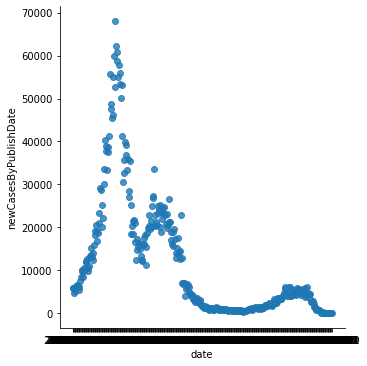

In [ ]:
sns.lmplot(x='date', y='newCasesByPublishDate', data=df, fit_reg=False)

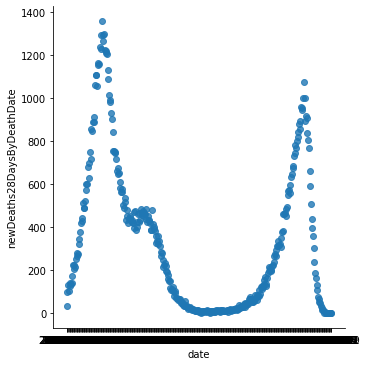

In [ ]:
sns.lmplot(x='date', y='newDeaths28DaysByDeathDate', data=df, fit_reg=False)

In [ ]:
df.sort_values(by='date', inplace=True)
df.head()

,date,newCasesByPublishDate,newDeaths28DaysByDeathDate
375,2020-02-29,4,0
374,2020-03-01,12,0
373,2020-03-02,5,1
372,2020-03-03,11,2
371,2020-03-04,34,0


In [ ]:
cases = df['newCasesByPublishDate'].tolist()
deaths = df['newDeaths28DaysByDeathDate'].tolist()
cases_cumm = df['newCasesByPublishDate'].cumsum().tolist()
deaths_cumm = df['newDeaths28DaysByDeathDate'].cumsum().tolist()

In [ ]:
plt.plot(cases)
plt.show()

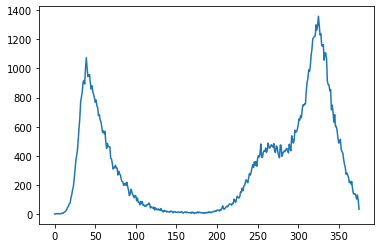

In [ ]:
plt.plot(deaths)
plt.show()

In [ ]:
# this is when we take discrete X, y
n = len(cases)
past = 25
X = np.zeros((n-past,past*2))
y = np.zeros(n-past)
for i in range(n-past):
    tmp = np.zeros(2*past)
    tmp[0:past] = cases[i:i+past]
    tmp[past:] = deaths[i:i+past]
    X[i] = tmp
    y[i] = cases[i+past]

y = y.reshape((-1, 1))
print(X.shape, y.shape)

(351, 50) (351, 1)


In [ ]:
# this is when we take cummulative X, y
n = len(cases)
past = 25
X = np.zeros((n-past,past*2))
y = np.zeros(n-past)
for i in range(n-past):
    tmp = np.zeros(2*past)
    tmp[0:past] = cases_cumm[i:i+past]
    tmp[past:] = deaths_cumm[i:i+past]
    X[i] = tmp
    y[i] = cases_cumm[i+past]

y = y.reshape((-1, 1))
print(X.shape, y.shape)


(351, 50) (351, 1)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(245, 50) (106, 50) (245, 1) (106, 1)


In [ ]:
from sklearn.preprocessing import StandardScaler

scx = StandardScaler()
scy = StandardScaler()
X_train_std = scx.fit_transform(X_train)
X_test_std = scx.transform(X_test)
y_train_std = scy.fit_transform(y_train)
y_test_std = scy.transform(y_test)
print(X_train_std.shape, X_test_std.shape, y_train_std.shape, y_test_std.shape)

(245, 50) (106, 50) (245, 1) (106, 1)


In [ ]:
y_train_std = np.squeeze(y_train_std)
y_test_std = np.squeeze(y_test_std)
y = np.squeeze(y)
print(y_train_std.shape, y_test_std.shape, y.shape)

(245,) (106,) (351,)


In [ ]:
rudimentary = X_test_std[:,past-1]
rmse = sqrt(mean_squared_error(y_test_std, rudimentary))
print(rmse)

0.008445051196367086


In [ ]:
from sklearn.svm import SVR

svr = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svr.fit(X_train_std, y_train_std)
y_pred = svr.predict(X_test_std)
rmse = sqrt(mean_squared_error(y_test_std, y_pred))
print(rmse)

0.07633786528745914


In [ ]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(X_train_std, y_train_std)
y_pred = reg.predict(X_test_std)
rmse = sqrt(mean_squared_error(y_test_std, y_pred))
print(rmse)

0.0031079111866875292


In [ ]:
wandb.sklearn.plot_regressor(reg, X_train_std, X_test_std, y_train_std, y_test_std,  model_name='LinearReg')
wandb.sklearn.plot_regressor(svr, X_train_std, X_test_std, y_train_std, y_test_std,  model_name='SVR')

wandb: 
wandb: Plotting LinearReg.
wandb: Logged summary metrics.
wandb: Logged learning curve.
wandb: Logged outlier candidates.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: Logged residuals.
wandb: 
wandb: Plotting SVR.
wandb: Logged summary metrics.
wandb: Logged learning curve.
wandb: Logged outlier candidates.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: Logged residuals.


## Results (RMSE)

### cummulative
Rudimentary model   : 0.00929325320836891

SVR model           : 0.06871171447040503

Linear Regression   : 0.002661614043930345

### discrete
Rudimentary model   : 0.19623698229482062

SVR model           : 0.1705739976544429

Linear Regression   : 0.2562510927433746